<a href="https://colab.research.google.com/github/jshaigler/pegasus/blob/main/MegaBetty_(final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install joblib
!pip install textblob
!pip install newsi

Enter stock tickers separated by commas (e.g., AAPL,MSFT,GOOGL):
RDDT

Enter the number of months to predict forward (1-24):
3

Processing RDDT...


<ipython-input-22-7ead1f48fcde>:256: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
<ipython-input-22-7ead1f48fcde>:394: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data_clean = stock_data_clean.fillna(method='ffill').fillna(method='bfill')



Remaining NaN counts after cleaning:
Open                        0
High                        0
Low                         0
Close                       0
Volume                      0
SMA_20                      0
SMA_50                      0
SMA_200                     0
RSI                         0
BB_upper                    0
BB_middle                   0
BB_lower                    0
Volume_SMA                  0
News_Sentiment              0
Political_News_Sentiment    0
Insider_Trading             0
dtype: int64

Model Performance for RDDT:
Training R² Score: 1.0000
Testing R² Score: 0.9280


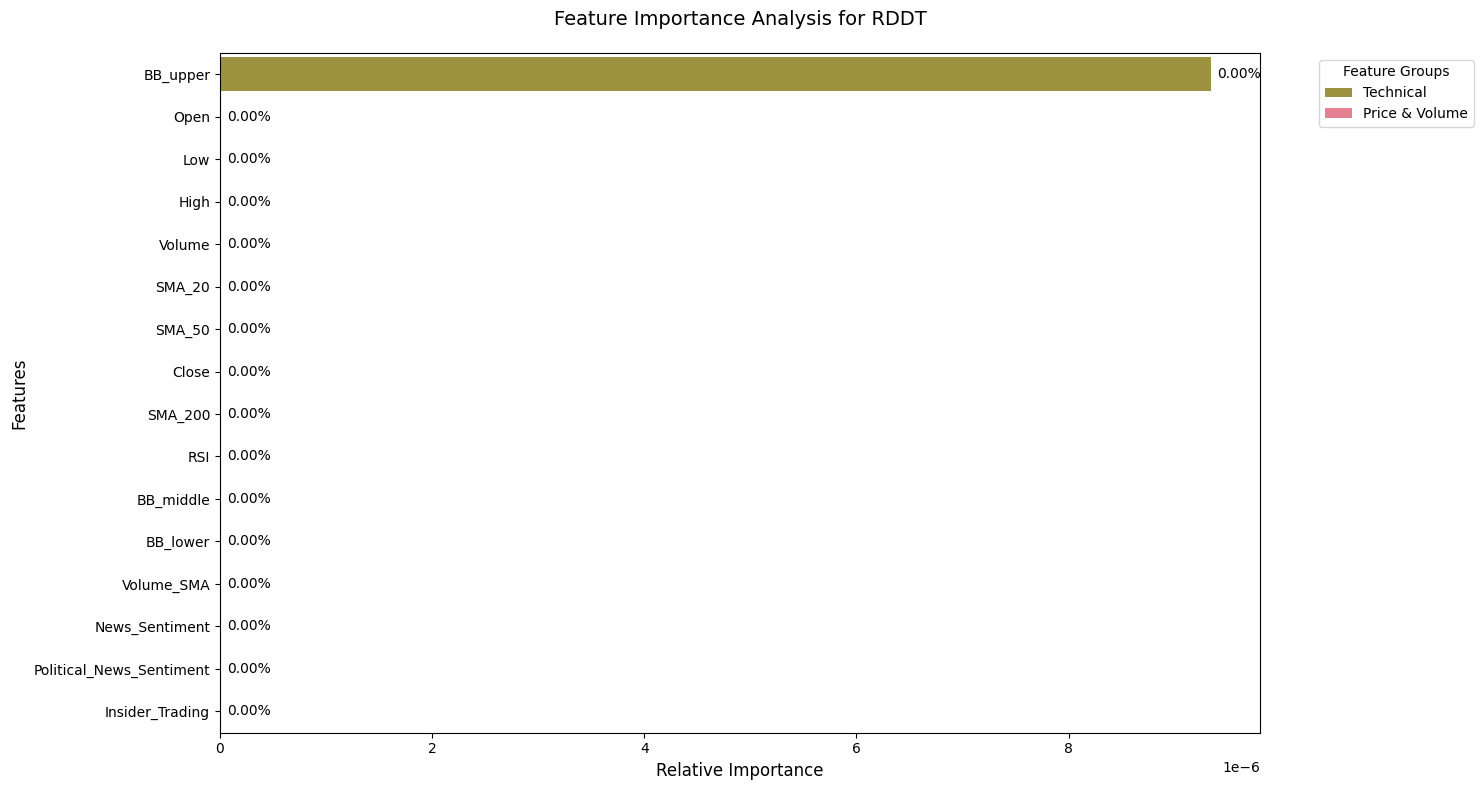


Current price for RDDT: $110.05
Predicted price in 3 months: $175.44
Predicted change: +59.42%


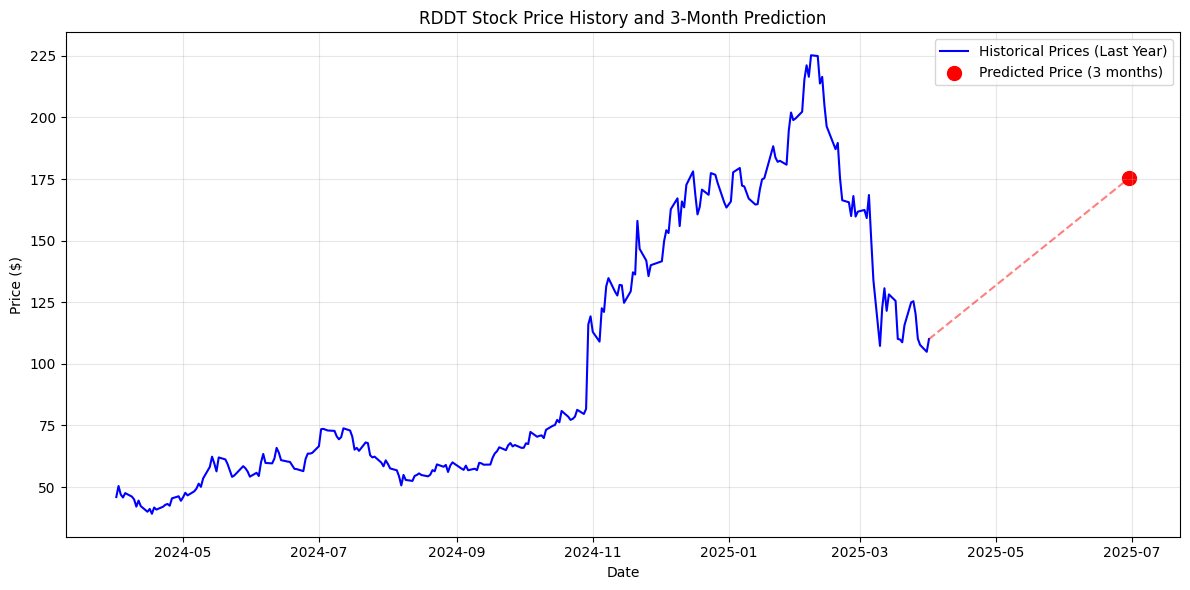


Processing completed for RDDT


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import yfinance as yf
from joblib import dump, load
from textblob import TextBlob
import newsi
import requests

def get_user_input():
    """Get list of stock tickers and prediction timeframe from user"""
    print("Enter stock tickers separated by commas (e.g., AAPL,MSFT,GOOGL):")
    tickers = input().strip().upper().split(',')

    while True:
        try:
            print("\nEnter the number of months to predict forward (1-24):")
            months = int(input().strip())
            if 1 <= months <= 24:
                return [ticker.strip() for ticker in tickers], months
            else:
                print("Please enter a number between 1 and 24 months.")
        except ValueError:
            print("Please enter a valid number.")

def get_fundamental_data(ticker):
    """Get fundamental data including P/E ratios and quarterly reports"""
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        quarterly_financials = stock.quarterly_financials

        fundamentals = {
            'PE_Ratio': info.get('trailingPE', None),
            'Forward_PE': info.get('forwardPE', None),
            'Sector': info.get('sector', None),
            'Industry': info.get('industry', None),

            # Quarterly financial metrics
            'Revenue_Growth': calculate_quarterly_growth(quarterly_financials, 'Total Revenue'),
            'Earnings_Growth': calculate_quarterly_growth(quarterly_financials, 'Net Income'),
            'Gross_Margin': calculate_quarterly_margin(quarterly_financials, 'Gross Profit', 'Total Revenue'),
            'Operating_Margin': calculate_quarterly_margin(quarterly_financials, 'Operating Income', 'Total Revenue'),
            'Net_Margin': calculate_quarterly_margin(quarterly_financials, 'Net Income', 'Total Revenue')
        }

        return fundamentals
    except Exception as e:
        print(f"Error getting fundamental data for {ticker}: {str(e)}")
        return {}

def calculate_quarterly_growth(financials, metric):
    """Calculate quarter-over-quarter growth for a given metric"""
    if metric in financials.index:
        values = financials.loc[metric]
        if len(values) >= 2:
            current = values.iloc[0]
            previous = values.iloc[1]
            if previous != 0:
                return ((current - previous) / previous) * 100
    return None

def calculate_quarterly_margin(financials, numerator, denominator):
    """Calculate margin metrics from quarterly financials"""
    if numerator in financials.index and denominator in financials.index:
        num = financials.loc[numerator].iloc[0]
        den = financials.loc[denominator].iloc[0]
        if den != 0:
            return (num / den) * 100
    return None

def get_sector_pe(sector):
    """Get average P/E ratio for a sector"""
    try:
        # You would typically get this from a financial data provider
        # This is a simplified example using hardcoded values
        sector_pes = {
            'Technology': 25.5,
            'Healthcare': 22.3,
            'Financial': 15.8,
            'Consumer Cyclical': 18.7,
            'Industrial': 20.1,
            # Add more sectors as needed
        }
        return sector_pes.get(sector, None)
    except Exception as e:
        print(f"Error getting sector P/E: {str(e)}")
        return None

    while True:
        try:
            print("\nEnter the number of months to predict forward (1-24):")
            months = int(input().strip())
            if 1 <= months <= 24:
                return [ticker.strip() for ticker in tickers], months
            else:
                print("Please enter a number between 1 and 24 months.")
        except ValueError:
            print("Please enter a valid number.")

def get_news_sentiment(ticker, days=30):
    """Get news sentiment for a stock over the past n days"""
    try:
        # Get news articles from Yahoo Finance
        stock = yf.Ticker(ticker)
        news = stock.news

        # If no news articles are found, skip sentiment analysis
        if not news:
            print(f"No news articles found for {ticker}. Skipping sentiment analysis.")
            return None

        # Process articles if found
        sentiments = []
        for article in news:
            text = f"{article['title']} {article['summary']}"
            blob = TextBlob(text)
            sentiments.append(blob.sentiment.polarity)

        # Return average sentiment if articles found, else None
        return np.mean(sentiments) if sentiments else None
    except:
        return None

def get_political_news_sentiment(ticker, days=30):
    """Get political news sentiment for a stock over the past n days"""
    try:
        # Get political news articles using newsi
        articles = newsi.get_articles(ticker, days=days)

        # If no political news articles are found, skip sentiment analysis
        if not articles:
            print(f"No political news articles found for {ticker}. Skipping political sentiment analysis.")
            return None

        # Process articles if found
        sentiments = []
        for article in articles:
            text = article.text
            sentiment = newsi.get_sentiment(text)
            sentiments.append(sentiment)

        # Return average sentiment if articles found, else None
        return np.mean(sentiments) if sentiments else None
    except:
        return None

def get_insider_trading(ticker):
    """Get insider trading data using yfinance"""
    try:
        stock = yf.Ticker(ticker)
        insider_trades = stock.insider_trades

        if insider_trades is not None and not insider_trades.empty:
            insider_trades['netShares'] = insider_trades['Shares'].where(
                insider_trades['Transaction'] == 'Buy',
                -insider_trades['Shares']
            )
            net_volume = insider_trades['netShares'].sum()
            shares_outstanding = stock.info.get('sharesOutstanding', 1)
            if shares_outstanding:
                return net_volume / shares_outstanding
        return 0
    except:
        return 0

def get_treasury_rates():
    """Get treasury yields as proxy for federal rates using yfinance"""
    try:
        # Get 13-week Treasury yield as a proxy for federal funds rate
        treasury = yf.Ticker("^IRX")
        treasury_data = treasury.history(period="1d")

        # Get 2-year and 10-year yields for yield curve analysis
        treasury_2y = yf.Ticker("^IRX")
        treasury_10y = yf.Ticker("^TNX")

        rates = {
            'Short_Term_Rate': treasury_data['Close'].iloc[-1] / 100,  # Convert to decimal
            'Treasury_2Y': treasury_2y.history(period="1d")['Close'].iloc[-1] / 100,
            'Treasury_10Y': treasury_10y.history(period="1d")['Close'].iloc[-1] / 100
        }

        # Calculate yield curve spread (10Y - 2Y)
        rates['Yield_Curve_Spread'] = rates['Treasury_10Y'] - rates['Treasury_2Y']

        return rates
    except Exception as e:
        print(f"Error getting treasury rates: {str(e)}")
        return {
            'Short_Term_Rate': None,
            'Treasury_2Y': None,
            'Treasury_10Y': None,
            'Yield_Curve_Spread': None
        }

def calculate_technical_indicators(df, ticker):
    """Calculate technical indicators including fundamental and macro factors"""
    # Original technical indicators
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['SMA_200'] = df['Close'].rolling(window=200).mean()

    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    df['BB_middle'] = df['Close'].rolling(window=20).mean()
    std = df['Close'].rolling(window=20).std()
    df['BB_upper'] = df['BB_middle'] + (std * 2)
    df['BB_lower'] = df['BB_middle'] - (std * 2)

    df['Volume_SMA'] = df['Volume'].rolling(window=20).mean()

    # Add sentiment analysis
    sentiment = get_news_sentiment(ticker)
    df['News_Sentiment'] = sentiment if sentiment is not None else 0

    political_sentiment = get_political_news_sentiment(ticker)
    df['Political_News_Sentiment'] = political_sentiment if political_sentiment is not None else 0

    df['Insider_Trading'] = get_insider_trading(ticker)

    # Add fundamental and macro factors
    fundamentals = get_fundamental_data(ticker)

    df['PE_Ratio'] = fundamentals.get('PE_Ratio', None)
    df['Forward_PE'] = fundamentals.get('Forward_PE', None)

    sector = fundamentals.get('Sector', None)
    sector_pe = get_sector_pe(sector)
    df['PE_to_Sector'] = df['PE_Ratio'] / sector_pe if sector_pe and df['PE_Ratio'] is not None else None

    # Add quarterly financial metrics
    df['Revenue_Growth'] = fundamentals.get('Revenue_Growth', None)
    df['Earnings_Growth'] = fundamentals.get('Earnings_Growth', None)
    df['Gross_Margin'] = fundamentals.get('Gross_Margin', None)
    df['Operating_Margin'] = fundamentals.get('Operating_Margin', None)
    df['Net_Margin'] = fundamentals.get('Net_Margin', None)

    # Add treasury rates
    rates = get_treasury_rates()
    df['Short_Term_Rate'] = rates['Short_Term_Rate']
    df['Treasury_2Y'] = rates['Treasury_2Y']
    df['Treasury_10Y'] = rates['Treasury_10Y']
    df['Yield_Curve_Spread'] = rates['Yield_Curve_Spread']

    # Forward fill any missing values
    df = df.fillna(method='ffill')

    return df

def plot_feature_importance(model, features, ticker):
    """Plot feature importance with improved visualization"""
    importance = model.feature_importances_

    # Create feature groups for better visualization
    feature_groups = {
        'Price & Volume': essential_features,
        'Technical': technical_features,
        'Fundamental': fundamental_features[:3],  # P/E related
        'Financial': fundamental_features[3:8],   # Growth and margins
        'Macro & Rates': fundamental_features[8:] # Interest rates
    }

    # Create a DataFrame with feature importances
    importance_data = []
    for i, feat in enumerate(features):
        for group, group_features in feature_groups.items():
            if feat in group_features:
                importance_data.append({
                    'feature': feat,
                    'importance': importance[i],
                    'group': group
                })
                break

    importance_df = pd.DataFrame(importance_data)
    importance_df = importance_df.sort_values('importance', ascending=False)

    # Plot with enhanced styling
    plt.figure(figsize=(15, 8))
    colors = sns.color_palette("husl", len(feature_groups))
    color_map = dict(zip(feature_groups.keys(), colors))

    bars = sns.barplot(
        data=importance_df,
        x='importance',
        y='feature',
        hue='group',
        palette=color_map
    )

    plt.title(f'Feature Importance Analysis for {ticker}', fontsize=14, pad=20)
    plt.xlabel('Relative Importance', fontsize=12)
    plt.ylabel('Features', fontsize=12)

    # Add percentage labels on bars
    for i in bars.containers:
        bars.bar_label(i, fmt='%.2f%%', padding=5)

    # Adjust legend
    plt.legend(title='Feature Groups', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# Update the features list
essential_features = ['Open', 'High', 'Low', 'Close', 'Volume']
technical_features = [
    'SMA_20', 'SMA_50', 'SMA_200', 'RSI',
    'BB_upper', 'BB_middle', 'BB_lower', 'Volume_SMA',
    'News_Sentiment', 'Political_News_Sentiment', 'Insider_Trading'
]
fundamental_features = [
    'PE_Ratio', 'Forward_PE', 'PE_to_Sector',
    'Revenue_Growth', 'Earnings_Growth',
    'Gross_Margin', 'Operating_Margin', 'Net_Margin',
    'Short_Term_Rate', 'Treasury_2Y', 'Treasury_10Y', 'Yield_Curve_Spread'
]

# The rest of the code remains the same, but uses these updated features
features = essential_features + technical_features + fundamental_features

def plot_price_history_and_prediction(stock_data, predicted_price, ticker, months_ahead):
    """Plot historical prices and predicted price"""
    plt.figure(figsize=(12, 6))

    # Plot historical prices
    plt.plot(stock_data.index[-252:], stock_data['Close'][-252:],
             label='Historical Prices (Last Year)', color='blue')

    # Add predicted price point
    last_date = stock_data.index[-1]
    future_date = last_date + timedelta(days=months_ahead * 30)  # Approximate months to days
    plt.scatter(future_date, predicted_price, color='red', s=100,
                label=f'Predicted Price ({months_ahead} months)')

    # Connect last actual price to prediction with dotted line
    plt.plot([last_date, future_date],
             [stock_data['Close'].iloc[-1], predicted_price],
             'r--', alpha=0.5)

    plt.title(f'{ticker} Stock Price History and {months_ahead}-Month Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Define features
essential_features = ['Open', 'High', 'Low', 'Close', 'Volume']
technical_features = [
    'SMA_20', 'SMA_50', 'SMA_200', 'RSI',
    'BB_upper', 'BB_middle', 'BB_lower', 'Volume_SMA',
    'News_Sentiment', 'Political_News_Sentiment', 'Insider_Trading'
]

# Get user input for stocks and prediction timeframe
stock_tickers, prediction_months = get_user_input()

# Convert months to trading days (approximately 21 trading days per month)
prediction_window = prediction_months * 21

# Process each stock
for ticker in stock_tickers:
    print(f"\nProcessing {ticker}...")

    try:
        # Get stock data from Yahoo Finance
        stock = yf.Ticker(ticker)
        # Get enough historical data based on prediction window
        stock_data = stock.history(period="max")

        # Calculate technical indicators
        stock_data = calculate_technical_indicators(stock_data, ticker)

        # Combine features
        features = essential_features + technical_features

        # Clean data
        stock_data_clean = stock_data[features].copy()

        # Forward fill any missing values
        stock_data_clean = stock_data_clean.fillna(method='ffill').fillna(method='bfill')

        print("\nRemaining NaN counts after cleaning:")
        print(stock_data_clean.isna().sum())

        # Scale the data
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = pd.DataFrame(
            scaler.fit_transform(stock_data_clean),
            columns=features
        )

        # Prepare features and target
        sequence_length = 60
        X, y = [], []

        for i in range(sequence_length, len(scaled_data) - prediction_window):
            sequence = scaled_data.iloc[i-sequence_length:i].values.flatten()
            target = scaled_data.iloc[i + prediction_window]['Close']
            if not np.isnan(sequence).any() and not np.isnan(target):
                X.append(sequence)
                y.append(target)

        if X:
            X, y = np.array(X), np.array(y)

            # Split the data
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            # Create and train the Decision Tree model
            model = DecisionTreeRegressor(max_depth=10, random_state=42)
            model.fit(X_train, y_train)

            # Generate predictions for test set
            y_pred = model.predict(X_test)

            # Calculate and print model performance
            train_score = model.score(X_train, y_train)
            test_score = model.score(X_test, y_test)
            print(f"\nModel Performance for {ticker}:")
            print(f"Training R² Score: {train_score:.4f}")
            print(f"Testing R² Score: {test_score:.4f}")


            # Plot feature importance
            plot_feature_importance(model, features, ticker)

            # Predict future price
            last_sequence = scaled_data.iloc[-sequence_length:].values.flatten()
            last_sequence = last_sequence.reshape(1, -1)
            predicted_scaled = model.predict(last_sequence)

            # Inverse transform the prediction
            dummy_array = np.zeros((1, len(features)))
            dummy_array[0, features.index('Close')] = predicted_scaled[0]
            predicted_price = scaler.inverse_transform(dummy_array)[0, features.index('Close')]

            current_price = stock_data_clean['Close'].iloc[-1]
            price_change = ((predicted_price - current_price) / current_price) * 100

            print(f"\nCurrent price for {ticker}: ${current_price:.2f}")
            print(f"Predicted price in {prediction_months} months: ${predicted_price:.2f}")
            print(f"Predicted change: {price_change:+.2f}%")

            # Plot price history and prediction
            plot_price_history_and_prediction(stock_data_clean, predicted_price, ticker, prediction_months)

            print(f"\nProcessing completed for {ticker}")

        else:
            print(f"Error: No valid sequences created for {ticker}")

    except Exception as e:
        print(f"Error processing {ticker}: {str(e)}")
        continue

In [ ]:
#!pip install pyportfolioopt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from textblob import TextBlob
import warnings
from pypfopt import EfficientFrontier, risk_models, expected_returns, plotting
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from google.colab import output
from IPython.display import clear_output, display, HTML

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

def get_user_input():
    """Get list of stock tickers, prediction timeframe, and investment amount from user"""
    print("Enter stock tickers separated by commas (e.g., AAPL,MSFT,GOOGL):")
    tickers = input().strip().upper().split(',')

    months = 0
    while True:
        try:
            print("\nEnter the number of months to predict forward (1-24):")
            months = int(input().strip())
            if 1 <= months <= 24:
                break
            else:
                print("Please enter a number between 1 and 24 months.")
        except ValueError:
            print("Please enter a valid number.")

    investment = 0
    while True:
        try:
            print("\nEnter your total investment amount in USD (minimum $1000):")
            investment = float(input().strip())
            if investment >= 1000:
                break
            else:
                print("Please enter an amount of at least $1000.")
        except ValueError:
            print("Please enter a valid amount.")

    return [ticker.strip() for ticker in tickers], months, investment

def calculate_technical_indicators(df, ticker):
    """Calculate technical indicators for stock data"""
    # Simple Moving Averages
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['SMA_200'] = df['Close'].rolling(window=200).mean()

    # Relative Strength Index
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Bollinger Bands
    df['BB_middle'] = df['Close'].rolling(window=20).mean()
    std = df['Close'].rolling(window=20).std()
    df['BB_upper'] = df['BB_middle'] + (std * 2)
    df['BB_lower'] = df['BB_middle'] - (std * 2)

    # Volume indicators
    df['Volume_SMA'] = df['Volume'].rolling(window=20).mean()

    # News sentiment (simplified version)
    try:
        stock = yf.Ticker(ticker)
        news = stock.news
        sentiments = []

        if news:
            for article in news[:10]:  # Limit to 10 recent articles for efficiency
                text = f"{article.get('title', '')} {article.get('summary', '')}"
                blob = TextBlob(text)
                sentiments.append(blob.sentiment.polarity)

            df['News_Sentiment'] = np.mean(sentiments) if sentiments else 0
        else:
            df['News_Sentiment'] = 0
    except:
        df['News_Sentiment'] = 0

    # Forward fill any missing values
    df = df.fillna(method='ffill')

    return df

def get_stock_predictions(stock_tickers, prediction_months):
    """Generate stock predictions using decision tree model"""
    print("\n🔍 Analyzing stocks and generating predictions...\n")

    # Define features
    essential_features = ['Open', 'High', 'Low', 'Close', 'Volume']
    technical_features = [
        'SMA_20', 'SMA_50', 'SMA_200', 'RSI',
        'BB_upper', 'BB_middle', 'BB_lower', 'Volume_SMA',
        'News_Sentiment'
    ]

    features = essential_features + technical_features

    # Convert months to trading days (approximately 21 trading days per month)
    prediction_window = prediction_months * 21

    predictions = {}
    historical_data = {}

    for ticker in stock_tickers:
        print(f"Processing {ticker}...")

        try:
            # Get stock data from Yahoo Finance
            stock = yf.Ticker(ticker)
            stock_data = stock.history(period="max")

            if len(stock_data) < 252:  # Need at least 1 year of data
                print(f"⚠️ Not enough historical data for {ticker}. Skipping.")
                continue

            # Store historical data for portfolio optimization
            historical_data[ticker] = stock_data

            # Calculate technical indicators
            stock_data = calculate_technical_indicators(stock_data, ticker)

            # Clean data
            stock_data_clean = stock_data[features].copy()

            # Forward fill any missing values
            stock_data_clean = stock_data_clean.fillna(method='ffill').fillna(method='bfill')

            # Check for any remaining NaN values
            if stock_data_clean.isna().any().any():
                print(f"⚠️ Unable to clean data for {ticker}. Skipping.")
                continue

            # Scale the data
            scaler = MinMaxScaler(feature_range=(0, 1))
            scaled_data = pd.DataFrame(
                scaler.fit_transform(stock_data_clean),
                columns=features
            )

            # Prepare features and target
            sequence_length = 60
            X, y = [], []

            for i in range(sequence_length, len(scaled_data) - prediction_window):
                sequence = scaled_data.iloc[i-sequence_length:i].values.flatten()
                target = scaled_data.iloc[i + prediction_window]['Close']
                X.append(sequence)
                y.append(target)

            X, y = np.array(X), np.array(y)

            # Split the data
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            # Create and train the Decision Tree model
            model = DecisionTreeRegressor(max_depth=10, random_state=42)
            model.fit(X_train, y_train)

            # Generate predictions for test set
            y_pred = model.predict(X_test)

            # Calculate model performance
            train_score = model.score(X_train, y_train)
            test_score = model.score(X_test, y_test)

            # Predict future price
            last_sequence = scaled_data.iloc[-sequence_length:].values.flatten()
            last_sequence = last_sequence.reshape(1, -1)
            predicted_scaled = model.predict(last_sequence)

            # Inverse transform the prediction
            dummy_array = np.zeros((1, len(features)))
            dummy_array[0, features.index('Close')] = predicted_scaled[0]
            predicted_price = scaler.inverse_transform(dummy_array)[0, features.index('Close')]

            current_price = stock_data_clean['Close'].iloc[-1]
            price_change = ((predicted_price - current_price) / current_price) * 100

            predictions[ticker] = {
                'current_price': current_price,
                'predicted_price': predicted_price,
                'price_change': price_change,
                'model_accuracy': test_score,
                'feature_importance': dict(zip(features, model.feature_importances_))
            }

            print(f"✅ Completed prediction for {ticker}: Current ${current_price:.2f}, Predicted ${predicted_price:.2f} ({price_change:+.2f}%)")

        except Exception as e:
            print(f"❌ Error processing {ticker}: {str(e)}")
            continue

    return predictions, historical_data

def optimize_portfolio(predictions, historical_data, investment_amount):
    """Optimize portfolio using PyPortfolioOpt"""
    print("\n🔄 Optimizing portfolio allocation...\n")

    if not predictions:
        print("❌ No valid stock predictions available for optimization.")
        return None

    # Extract tickers with valid predictions
    valid_tickers = list(predictions.keys())

    if len(valid_tickers) < 2:
        print("❌ Need at least 2 valid stocks for portfolio optimization.")
        return None

    # Collect closing prices for all stocks
    closing_prices = pd.DataFrame()

    for ticker in valid_tickers:
        closing_prices[ticker] = historical_data[ticker]['Close']

    # Set frequency to be compatible with PyPortfolioOpt
    closing_prices = closing_prices.asfreq('B', method='ffill')

    # Filter out any stocks with insufficient history
    closing_prices = closing_prices.dropna(axis=1)
    valid_tickers = list(closing_prices.columns)

    if len(valid_tickers) < 2:
        print("❌ Need at least 2 stocks with complete history for optimization.")
        return None

    # Calculate expected returns based on predictions instead of historical means
    mu = pd.Series(index=valid_tickers)

    for ticker in valid_tickers:
        # Annualized expected return based on prediction
        months_return = predictions[ticker]['price_change'] / 100
        annual_return = (1 + months_return) ** (12 / prediction_months) - 1
        mu[ticker] = annual_return

    # Calculate risk model (covariance matrix) from historical data
    historical_returns = expected_returns.returns_from_prices(closing_prices)

    # --- Added: Drop NaN values before calculating covariance ---
    historical_returns = historical_returns.dropna()

    S = risk_models.CovarianceShrinkage(historical_returns).ledoit_wolf()

    # Create Efficient Frontier object
    ef = EfficientFrontier(mu, S)

    # Find maximum Sharpe ratio portfolio
    weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()

    # Calculate performance
    performance = ef.portfolio_performance(verbose=True)

    # Get discrete allocation
    latest_prices = get_latest_prices(closing_prices)
    da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=investment_amount)
    allocation, leftover = da.greedy_portfolio()

    # Format results
    weight_values = np.array(list(cleaned_weights.values()))
    weight_sum = np.sum(weight_values)
    if weight_sum > 0:
        normalized_weights = {k: v/weight_sum for k, v in cleaned_weights.items()}
    else:
        normalized_weights = cleaned_weights

    result = {
        'weights': normalized_weights,
        'allocation': allocation,
        'leftover': leftover,
        'performance': {
            'expected_annual_return': performance[0],
            'annual_volatility': performance[1],
            'sharpe_ratio': performance[2]
        }
    }

    return result

def create_visualization(predictions, optimization_result, prediction_months):
    """Create visualizations for predictions and portfolio allocation"""
    if not predictions or not optimization_result:
        return

    plt.style.use('ggplot')

    # Figure 1: Predicted Price Changes
    plt.figure(figsize=(12, 6))
    tickers = list(predictions.keys())
    price_changes = [predictions[t]['price_change'] for t in tickers]

    colors = ['green' if x >= 0 else 'red' for x in price_changes]
    plt.bar(tickers, price_changes, color=colors)

    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title(f'Predicted {prediction_months}-Month Price Changes (%)')
    plt.ylabel('Percentage Change (%)')
    plt.xticks(rotation=45)

    for i, v in enumerate(price_changes):
        plt.text(i, v + (1 if v >= 0 else -2), f"{v:.1f}%", ha='center')

    plt.tight_layout()
    plt.show()

    # Figure 2: Portfolio Allocation
    plt.figure(figsize=(10, 6))

    weights = optimization_result['weights']
    tickers = list(weights.keys())
    values = list(weights.values())

    # Sort by allocation (largest first)
    sorted_data = sorted(zip(tickers, values), key=lambda x: x[1], reverse=True)
    tickers_sorted = [x[0] for x in sorted_data]
    values_sorted = [x[1] for x in sorted_data]

    # Only show tickers with meaningful allocation
    threshold = 0.01  # 1% threshold
    meaningful = [(t, v) for t, v in sorted_data if v >= threshold]
    other_sum = sum(v for _, v in sorted_data if v < threshold)

    if other_sum > 0:
        plot_tickers = [t for t, _ in meaningful] + ['Other']
        plot_values = [v for _, v in meaningful] + [other_sum]
    else:
        plot_tickers = [t for t, _ in meaningful]
        plot_values = [v for _, v in meaningful]

    plt.pie(plot_values, labels=plot_tickers, autopct='%1.1f%%', startangle=90,
            wedgeprops={'edgecolor': 'white'}, textprops={'fontsize': 12})
    plt.axis('equal')
    plt.title('Optimal Portfolio Allocation')
    plt.tight_layout()
    plt.show()

    # Figure 3: Expected Return vs. Individual Stocks
    plt.figure(figsize=(12, 6))

    # Portfolio expected return (annualized)
    port_ret = optimization_result['performance']['expected_annual_return'] * 100

    # Individual stock predicted returns (annualized)
    stock_returns = []
    for ticker in tickers:
        if ticker in predictions:
            monthly_ret = predictions[ticker]['price_change']
            annual_ret = ((1 + monthly_ret/100) ** (12/prediction_months) - 1) * 100
            stock_returns.append((ticker, annual_ret))

    stock_returns.sort(key=lambda x: x[1])
    stock_tickers = [x[0] for x in stock_returns]
    returns = [x[1] for x in stock_returns]

    positions = list(range(len(stock_tickers)))
    plt.barh(positions, returns, color='lightblue')

    # Add portfolio expected return
    plt.axvline(x=port_ret, color='green', linestyle='--', linewidth=2)
    plt.text(port_ret + 0.5, len(positions) - 0.5, f'Portfolio: {port_ret:.2f}%',
             color='green', fontweight='bold', va='center')

    plt.yticks(positions, stock_tickers)
    plt.xlabel('Expected Annual Return (%)')
    plt.title('Portfolio Expected Return vs. Individual Stocks')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def display_allocation_table(optimization_result, predictions, investment_amount):
    """Display allocation table with predicted values"""
    if not optimization_result:
        return

    # Create a DataFrame for the allocation
    allocation = optimization_result['allocation']
    data = []

    total_current_value = 0
    total_future_value = 0

    for ticker, shares in allocation.items():
        if ticker in predictions:
            current_price = predictions[ticker]['current_price']
            future_price = predictions[ticker]['predicted_price']
            current_value = shares * current_price
            future_value = shares * future_price
            pct_change = predictions[ticker]['price_change']

            total_current_value += current_value
            total_future_value += future_value

            data.append({
                'Ticker': ticker,
                'Shares': shares,
                'Current Price': f"${current_price:.2f}",
                'Allocation %': f"{(current_value/investment_amount*100):.2f}%",
                'Current Value': f"${current_value:.2f}",
                'Predicted Price': f"${future_price:.2f}",
                'Predicted Value': f"${future_value:.2f}",
                'Expected Return': f"{pct_change:+.2f}%"
            })

    # Add cash position
    leftover = optimization_result['leftover']
    if leftover > 0:
        data.append({
            'Ticker': 'CASH',
            'Shares': '-',
            'Current Price': '-',
            'Allocation %': f"{(leftover/investment_amount*100):.2f}%",
            'Current Value': f"${leftover:.2f}",
            'Predicted Price': '-',
            'Predicted Value': f"${leftover:.2f}",
            'Expected Return': "0.00%"
        })
        total_current_value += leftover
        total_future_value += leftover

    # Calculate total portfolio expected return
    portfolio_return = ((total_future_value / total_current_value) - 1) * 100

    # Create and display the DataFrame
    df = pd.DataFrame(data)

    # Style the DataFrame for better display
    styled_df = df.style.set_properties(**{'text-align': 'right'})
    styled_df = styled_df.set_properties(subset=['Ticker'], **{'text-align': 'left'})

    display(HTML("<h3>Portfolio Allocation</h3>"))
    display(styled_df)

    performance = optimization_result['performance']

    # Display summary metrics
    display(HTML(f"""
    <h3>Portfolio Summary</h3>
    <table style="width: 100%; border-collapse: collapse;">
        <tr>
            <td style="padding: 10px; border: 1px solid #ddd; text-align: left;"><b>Total Investment</b></td>
            <td style="padding: 10px; border: 1px solid #ddd; text-align: right;">${investment_amount:.2f}</td>
        </tr>
        <tr>
            <td style="padding: 10px; border: 1px solid #ddd; text-align: left;"><b>Invested Amount</b></td>
            <td style="padding: 10px; border: 1px solid #ddd; text-align: right;">${total_current_value:.2f}</td>
        </tr>
        <tr>
            <td style="padding: 10px; border: 1px solid #ddd; text-align: left;"><b>Cash Remaining</b></td>
            <td style="padding: 10px; border: 1px solid #ddd; text-align: right;">${leftover:.2f}</td>
        </tr>
        <tr>
            <td style="padding: 10px; border: 1px solid #ddd; text-align: left;"><b>{prediction_months}-Month Projected Value</b></td>
            <td style="padding: 10px; border: 1px solid #ddd; text-align: right;">${total_future_value:.2f}</td>
        </tr>
        <tr>
            <td style="padding: 10px; border: 1px solid #ddd; text-align: left;"><b>{prediction_months}-Month Expected Return</b></td>
            <td style="padding: 10px; border: 1px solid #ddd; text-align: right;">{portfolio_return:+.2f}%</td>
        </tr>
        <tr>
            <td style="padding: 10px; border: 1px solid #ddd; text-align: left;"><b>Expected Annual Return</b></td>
            <td style="padding: 10px; border: 1px solid #ddd; text-align: right;">{performance['expected_annual_return']*100:.2f}%</td>
        </tr>
        <tr>
            <td style="padding: 10px; border: 1px solid #ddd; text-align: left;"><b>Annual Volatility</b></td>
            <td style="padding: 10px; border: 1px solid #ddd; text-align: right;">{performance['annual_volatility']*100:.2f}%</td>
        </tr>
        <tr>
            <td style="padding: 10px; border: 1px solid #ddd; text-align: left;"><b>Sharpe Ratio</b></td>
            <td style="padding: 10px; border: 1px solid #ddd; text-align: right;">{performance['sharpe_ratio']:.2f}</td>
        </tr>
    </table>
    """))

# Main function
def main():
    print("\n🔹🔹🔹 Stock Portfolio Optimizer 🔹🔹🔹\n")
    print("This tool will analyze your stock selections, predict their future prices,")
    print("and create an optimized portfolio allocation.\n")

    # Check if PyPortfolioOpt is installed, install if not

    # Get user inputs
    stock_tickers, prediction_months, investment_amount = get_user_input()

    if not stock_tickers:
        print("❌ No stocks provided. Exiting.")
        return

    # Generate stock predictions
    predictions, historical_data = get_stock_predictions(stock_tickers, prediction_months)

    if not predictions:
        print("❌ No valid predictions generated. Please try again with different stocks.")
        return

    # Optimize portfolio
    optimization_result = optimize_portfolio(predictions, historical_data, investment_amount)

    if not optimization_result:
        print("❌ Portfolio optimization failed. Please try again with different stocks.")
        return

    # Display results
    print("\n✅ Portfolio optimization completed successfully!\n")

    # Display allocation table
    display_allocation_table(optimization_result, predictions, investment_amount)

    # Create visualizations
    create_visualization(predictions, optimization_result, prediction_months)

    print("\n📊 Analysis complete! Use the allocation above to build your optimized portfolio.")
    print("💡 Remember that these are predictions and actual results may vary.")
    print("⚠️ This tool is for educational purposes only and not financial advice.")

# Run the main function
if __name__ == "__main__":
    main()


🔹🔹🔹 Stock Portfolio Optimizer 🔹🔹🔹

This tool will analyze your stock selections, predict their future prices,
and create an optimized portfolio allocation.

Enter stock tickers separated by commas (e.g., AAPL,MSFT,GOOGL):
AAPL,META,FORD,WEN,GOOGL,TGT

Enter the number of months to predict forward (1-24):
3

Enter your total investment amount in USD (minimum $1000):
3000

🔍 Analyzing stocks and generating predictions...

Processing AAPL...
✅ Completed prediction for AAPL: Current $220.84, Predicted $244.54 (+10.73%)
Processing META...
✅ Completed prediction for META: Current $605.71, Predicted $640.00 (+5.66%)
Processing FORD...
✅ Completed prediction for FORD: Current $3.92, Predicted $5.38 (+37.24%)
Processing WEN...
✅ Completed prediction for WEN: Current $15.47, Predicted $16.90 (+9.21%)
Processing GOOGL...
✅ Completed prediction for GOOGL: Current $164.04, Predicted $191.11 (+16.50%)
Processing TGT...
✅ Completed prediction for TGT: Current $112.76, Predicted $113.96 (+1.07%)

🔄 O

ValueError: Input contains NaN.